<h1 align="center"> ** Numerical Optimization** </h1>
<h2 align="center">  *1st Programming Assignment* </h2>
<h3 align="center">  Alex Karvouniaris </h3>

At first, we will create 2 functions to generate the matrices B and A.

In [1]:
import numpy as np
def B_matrix(n):
    dim=(n,n)
    B_n=np.zeros(dim)
    rows,cols=np.indices(dim)
    row_vals_0=np.diag(rows,k=0)
    col_vals_0=np.diag(cols,k=0)
    row_vals_1=np.diag(rows,k=1)
    col_vals_1=np.diag(cols,k=1)
    row_vals__1=np.diag(rows,k=-1)
    col_vals__1=np.diag(cols,k=-1)
    row_vals_2=np.diag(rows,k=2)
    col_vals_2=np.diag(cols,k=2)
    row_vals__2=np.diag(rows,k=-2)
    col_vals__2=np.diag(cols,k=-2)
    B_n[row_vals_0,col_vals_0]=6
    B_n[row_vals_1,col_vals_1]=-4
    B_n[row_vals__1,col_vals__1]=-4
    B_n[row_vals_2,col_vals_2]=1
    B_n[row_vals__2,col_vals__2]=1
    return(B_n)

In [3]:
B_matrix(4)

array([[ 6., -4.,  1.,  0.],
       [-4.,  6., -4.,  1.],
       [ 1., -4.,  6., -4.],
       [ 0.,  1., -4.,  6.]])

Now we are going to create a function that generates A matrix through cronecker sum of matrix B. $$A=B\otimes I + I\otimes B$$

In [4]:
def A_matrix(bmatrix):
    dim=bmatrix.shape[0]
    A_nn=np.kron(bmatrix,np.eye(dim))+np.kron(np.eye(dim),bmatrix)
    return(A_nn)

In [7]:
A_matrix(B_matrix(3))

array([[ 12.,  -4.,   1.,  -4.,  -0.,   0.,   1.,   0.,   0.],
       [ -4.,  12.,  -4.,  -0.,  -4.,  -0.,   0.,   1.,   0.],
       [  1.,  -4.,  12.,   0.,  -0.,  -4.,   0.,   0.,   1.],
       [ -4.,  -0.,   0.,  12.,  -4.,   1.,  -4.,  -0.,   0.],
       [ -0.,  -4.,  -0.,  -4.,  12.,  -4.,  -0.,  -4.,  -0.],
       [  0.,  -0.,  -4.,   1.,  -4.,  12.,   0.,  -0.,  -4.],
       [  1.,   0.,   0.,  -4.,  -0.,   0.,  12.,  -4.,   1.],
       [  0.,   1.,   0.,  -0.,  -4.,  -0.,  -4.,  12.,  -4.],
       [  0.,   0.,   1.,   0.,  -0.,  -4.,   1.,  -4.,  12.]])

In order to solve the system $Ax=b$, with b being a column matrix of ones and dimension $n^2$, we are going to use block Cholesky method. Recall that Cholesky method assumes that matrix A is symmetric and positive definite. At first, it is self-evident that matrix A in its block form is symmetric. As far as the positive definite property is concerned, we can use Gershgorin theorem: A is positive definite iff A strictly diagonally dominant and has positive diagonal elements. Another way to prove positive definiteness is by checking if Cholesky decomposition is completed.

The method we implemented is a block-recursive cholesky with block size $n\times n$, based mainly on  Block Algorithm and Its Implementation for Cholesky Factorization, (https://www.google.gr/search?q=Block+Algorithm+and+Its+Implementation+for+Cholesky+Factorization&rlz=1C1CHBD_enGR732GR732&oq=Block+Algorithm+and+Its+Implementation+for+Cholesky+Factorization&aqs=chrome..69i57.418j0j4&sourceid=chrome&ie=UTF-8) and dahlquist's book. In each step, we partition the matrix in 4 blocks and after we cholesky decompose the upper left part (of size $n\times n$) and solve the rest of the system except of the lower right block. Based on this block's dimensions, we choose whether to recursively call our function on this block or cholesky decompose this last block. In order to make this happen, we use two global variables to keep count of the number of times we call our function and to fill the resulting lowet triangular matrix. 

In [8]:
#block recursive cholesky
#dimension of B matrix- the only parameter that needs to be set
kapa=3
#
import scipy.linalg as slin
import time
import numpy as np
A=A_matrix(B_matrix(kapa))
invcount=0
big_L=np.zeros(A.shape)
#dimensions
d=int(np.sqrt(A.shape[0]))
dim=A.shape[0]
def block_chol(A_mat,n):
    global invcount
    global big_L
    #blocking
    A_11=A_mat[0:d,0:d]
    A_12=A_mat[0:d,d:dim]
    A_21=A_mat[d:dim,0:d]
    A_22=A_mat[d:dim,d:dim]
    #cholesky A_11
    L_11=slin.cholesky(A_11,lower=True)
    big_L[invcount*d:((invcount+1)*d),invcount*d:((invcount+1)*d)]=L_11
    #inverse L11
    L_11_inv=slin.inv(L_11)
    #compute L21
    L_21T=np.dot(L_11_inv,A_12)
    L_21=np.transpose(L_21T)
    big_L[((invcount+1)*d):dim,invcount*d:((invcount+1)*d)]=L_21
    #compute _A22_
    _A22_=A_22-np.dot(L_21,L_21T)
    #conditioning-recursion
    if _A22_.shape[0]<=d:
        L_22=slin.cholesky(_A22_,lower=True)
        big_L[-d:,-d:]=L_22
        return(invcount,big_L)
    else:
        invcount+=1
        return(block_chol(_A22_,d))
t0=time.time()    
factorized=block_chol(A,d)
time_elapsed=time.time()-t0
factorized

(1, array([[ 3.46410162,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [-1.15470054,  3.26598632,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.28867513, -1.1226828 ,  3.26439121,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [-1.15470054, -0.40824829, -0.03829198,  3.24014409,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -1.22474487, -0.42121177, -1.393805  ,  2.89480367,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -1.22534333,  0.29414716, -1.4184538 ,
          2.89827535,  0.        ,  0.        ,  0.        ],
        [ 0.28867513,  0.10206207,  0.00957299, -1.11866427, -0.49404649,
         -0.1242118 ,  3.22416471,  0.        ,  0.        ],
        [ 0.        ,  0.30618622,  0.1053029

In [9]:
time.strftime("%H:%M:%S:%m",time.gmtime(time_elapsed))

'00:00:00:01'

The function below is a simple numpy way to check whether a matrix is lower triangular.

In [10]:
np.allclose(factorized[1],np.tril(factorized[1]))

True

Now that we have acquired the Cholesky decomposition of A, we will exploit cho_solve function which solves a linear system, given a Cholesky decomposition. We have also cross-checked through various ways that our solutions are correct. 

In [11]:
b=np.repeat(1,dim)
matrixA=(np.matrix(factorized[1]),True)
x=slin.cho_solve(matrixA,b)
print("Solutions:\n",x)

Solutions:
 [ 0.42307692  0.61538462  0.42307692  0.61538462  0.90384615  0.61538462
  0.42307692  0.61538462  0.42307692]


As far as the number of flops is concerned, it would not be that difficult to count the number of flops if we used a function based only on itself (not use external modules). After searching for an efficient module that can count the number of flops, we concluded that there is none that does the job as we want it to (if you know about any, please share). Instead of calculating the flops in a programming way, we will measure it assymptotically. The procedure we go through involves n-steps of cholesky an $n\times n$ matrix($\frac{1}{3}n^3$), inverse the decomposed lower triangular($\frac{1}{3}n^3$), multiply a lower triangular with a rectangular and lastly multiply a rectangular with a rectangular, both operations at the order of $n^3$. As the aforementioned paper states, the total number of float multiplication and divisions is at the order of $\frac{n^3}{6}+\frac{n^2}{2}$, given that we use blocks of dimension n.

## Calculating relative error and time elapsed

In [56]:
kapa=2
A=A_matrix(B_matrix(kapa))
invcount=0
big_L=np.zeros(A.shape)
d=int(np.sqrt(A.shape[0]))
dim=A.shape[0]
b=np.repeat(1,dim)
t0=time.time()
nN=block_chol(A,d)
time_elapsed=time.time()-t0
b=np.repeat(1,dim)
matrixA=(np.matrix(nN[1]),True)
x=slin.cho_solve(matrixA,b)
residual=np.dot(matrixA[0],x)-b
relative_error_=slin.norm(residual)/slin.norm(b)
relative_error_,time_elapsed

(0.59730822171010534, 0.0005013942718505859)

During testing for time and accuracy performance, we encountered memory problems for n=128. Trying to dribble the problem and since the point of the question is about finding the effect of n on these performances, we followed an increasing loop on dimension by 2 and monitored error and time. 

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
plot_data=pd.DataFrame(columns=['relative error','time elapsed'],index=np.arange(2,82,step=2))
#plot_data
counter=0
for i in range(2,82,2):
    A=A_matrix(B_matrix(i))
    invcount=0
    big_L=np.zeros(A.shape)
    d=int(np.sqrt(A.shape[0]))
    dim=A.shape[0]
    b=np.repeat(1,dim)
    t0=time.time()
    nN=block_chol(A,d)
    time_elapsed=time.time()-t0
    b=np.repeat(1,dim)
    matrixA=(np.matrix(nN[1]),True)
    x=slin.cho_solve(matrixA,b)
    residual=np.dot(matrixA[0],x)-b
    relative_error_=slin.norm(residual)/slin.norm(b)
    time_=time.strftime("%H:%M:%S:%m",time.gmtime(time_elapsed))
    plot_data.iloc[counter,0],plot_data.iloc[counter,1]=relative_error_,time_
    counter+=1

In [51]:
plot_data

,relative error,time elapsed
2,0.597308,00
4,1.02624,00
6,2.20546,00
8,3.89325,00
10,6.05834,00
12,8.70587,00
14,11.8455,00
16,15.4866,00
18,19.6373,00
20,24.3047,00


In [67]:
def get_sec(time_str):
    h, m, s,mili = time_str.split(':')
    return(s)
end=plot_data.shape[0]
for i in range(end):
    plot_data.iloc[i,1]=get_sec(plot_data.iloc[i,1])
plot_data['time elapsed']=pd.to_numeric(plot_data['time elapsed'])
plot_data['relative error']=pd.to_numeric(plot_data['relative error'])

In [68]:
plot_data.dtypes

relative error    float64
time elapsed        int64
dtype: object

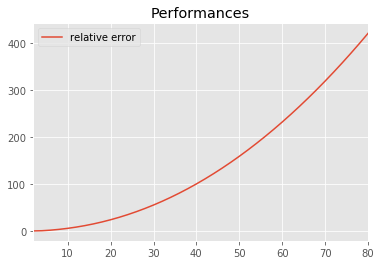

In [102]:
import matplotlib
matplotlib.style.use('ggplot')
plt.figure()
plot_data['relative error'].plot()
plt.legend()
plt.title('Performances')
plt.show()

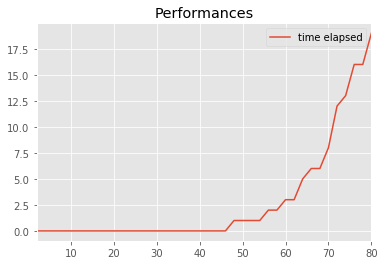

In [103]:
import matplotlib
matplotlib.style.use('ggplot')
plt.figure()
plot_data['time elapsed'].plot()
plt.legend()
plt.title('Performances')
plt.show()

The first graph of relative error depicts that the relationship between n and relative error is hyperlinear. A result like that is not good at first, because it indicates that as n grows we could be calculating an entirely different thing than the one we want. However, it would be wise to iterate over alternative direct methods for linear systems and compare their relative errors over n to obtain a hint on what method should we use. The time performance is again hyperlinear, a result with no particular apparent problems. We could use miliseconds to on x-axis to evade 0 values, though seconds seemed to be more natural. 